# Deep Q-Networks and Beyond

Implement a Deep Q-Network using both Double DQN and Dueling DQN.

The agent learns to solve a navigation task in a basic grid world.

This model makes a few improvements on the ordinary Q-network:

1. Going from a single-layer network to a multi-layer convolutional network.
2. Implementing Experience Replay, which allows our network to train itself using stored memories from it’s experience.
3. Utilizing a second “target” network, which we use to compute target Q-values during updates.

It was these three innovations that enabled the Google DeepMind team to achieve superhuman performance on dozens of Atari games using a DQN agent.

### Model Architecture

Convolutional layers. Instead of considering each pixel independently, convolutional layers allow us to consider regions of an image, and maintain spatial relationships between the objects on the screen as we send information up to higher levels of the network. In this way, they act similarly to human receptive fields.

Experience Replay. The basic idea is that by storing an agent’s experiences, and then randomly drawing batches of them to train the network, we can more robustly learn to perform well in the task. By keeping the experiences we draw random, we prevent the network from only learning about what it is immediately doing in the environment, and allow it to learn from a more varied array of past experiences. Each of these experiences are stored as a tuple of <state,action,reward,next state>. The Experience Replay buffer stores a fixed number of recent memories, and as new ones come in, old ones are removed. When the time comes to train, we simply draw a uniform batch of random memories from the buffer, and train our network with them.

Separate Target Network. This second network is used to generate the target-Q values that will be used to compute the loss for every action during training. Why not use just use one network for both estimations? The issue is that at every step of training, the Q-network’s values shift, and if we are using a constantly shifting set of values to adjust our network values, then the value estimations can easily spiral out of control. The network can become destabilized by falling into feedback loops between the target and estimated Q-values. In order to mitigate that risk, the target network’s weights are fixed, and only periodically or slowly updated to the primary Q-networks values. In this way training can proceed in a more stable manner.

Instead of updating the target network periodically and all at once, we will be updating it frequently, but slowly. This technique was introduced in another DeepMind paper (https://arxiv.org/pdf/1509.02971.pdf), where they found that it stabilized the training process.

In [1]:
from gridworld import GameEnvironment
import gym
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import scipy.misc
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tqdm import trange
%matplotlib inline

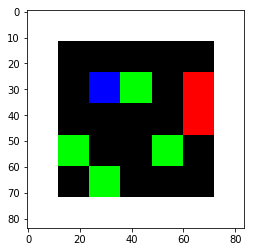

In [2]:
env = GameEnvironment(partial=False, size=5)

Above is an example of a starting environment in our simple game. The agent controls the blue square, and can move up, down, left, or right. The goal is to move to the green square (for +1 reward) and avoid the red square (for -1 reward). The position of the three blocks is randomized every episode.

### Implementing the network

In [3]:
class QNetwork(object):
    
    def __init__(self, n_hidden, n_actions):
        # The network receives a frame from the game, flattened into an array.
        # It then resizes and processes it through four convolutional layers.
        self.scalar_input = tf.placeholder(shape=[None, 21168], dtype=tf.float32)
        self.image_in = tf.reshape(self.scalar_input, shape=[-1, 84, 84, 3])
        self.conv1 = slim.conv2d(inputs=self.image_in, num_outputs=32,
                                 kernel_size=[8, 8], stride=[4, 4], padding='VALID', 
                                 biases_initializer=None)
        self.conv2 = slim.conv2d(inputs=self.conv1, num_outputs=64,
                                 kernel_size=[4, 4], stride=[2, 2], padding='VALID', 
                                 biases_initializer=None)
        self.conv3 = slim.conv2d(inputs=self.conv2, num_outputs=64,
                                 kernel_size=[3, 3], stride=[1, 1], padding='VALID', 
                                 biases_initializer=None)
        self.conv4 = slim.conv2d(inputs=self.conv3, num_outputs=n_hidden,
                                 kernel_size=[7, 7], stride=[1, 1], padding='VALID', 
                                 biases_initializer=None)
        
        # take the output from the final convolutional layer and split it into 
        # separate advantage and value streams
        self.stream_ac, self.stream_vc = tf.split(self.conv4, 2, 3)
        self.stream_a = slim.flatten(self.stream_ac)
        self.stream_v = slim.flatten(self.stream_vc)
        xavier_init = tf.contrib.layers.xavier_initializer()
        self.aw = tf.Variable(xavier_init([n_hidden // 2, n_actions]))
        self.vw = tf.Variable(xavier_init([n_hidden // 2, 1]))
        self.advantage = tf.matmul(self.stream_a, self.aw)
        self.value = tf.matmul(self.stream_v, self.vw)
        
        # then combine them together to get our final Q-values
        self.q_out = self.value + tf.subtract(self.advantage, tf.reduce_mean(self.advantage, axis=1, keepdims=True))
        self.predict = tf.argmax(self.q_out, 1)
        
        # obtain the loss by taking the sum of squares difference between 
        # the target and predicted Q-values
        self.target_q = tf.placeholder(shape=[None], dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions, n_actions, dtype=tf.float32)
        
        self.q = tf.reduce_sum(tf.multiply(self.q_out, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.target_q - self.q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.update_op = self.trainer.minimize(self.loss)

### Experience Replay

This class lets us store experiences, then sample them randomly to train the network.

In [4]:
class ExperienceBuffer(object):
    
    def __init__(self, buffer_size=50000):
        self.buffer = []
        self.buffer_size = buffer_size
        
    def add(self, experience):
        n = len(self.buffer) + len(experience)
        if n >= self.buffer_size:
            self.buffer[0:n-self.buffer_size] = []
            
        self.buffer.extend(experience)
        
    def sample(self, size):
        return np.reshape(np.array(random.sample(self.buffer, size)), [size, 5])

In [5]:
def process_state(states):
    """ resize game frames """
    return np.reshape(states, [21168])

In [6]:
def update_target_graph(tf_vars, tau):
    """ update the parameters of our target network with those of the primary network """
    n_vars = len(tf_vars)
    op_holder = []
    for i, var in enumerate(tf_vars[0:n_vars//2]):
        op_holder.append(tf_vars[i + n_vars//2].assign(var.value() * tau + 
                                                       (1 - tau) * tf_vars[i + n_vars//2].value()))
    return op_holder

In [7]:
def update_target(op_holder, sess):
    for op in op_holder:
        sess.run(op)

### Train the network

In [8]:
# hyperparams:

batch_size = 32  # number experiences to use for each training step
update_freq = 4  # frequency of performing a training step
gamma = 0.99  # discount factor on the target Q-values
start_epsilon = 1  # starting chance of random action
end_epsilon = 0.1  # final chance of random action
annealing_steps = 10000  # number steps of training to reduce start_epsilon to end_epsilon
#n_episodes = 10000  # number episodes of game environment to train network
n_episodes = 500
n_pretrain_steps = 10000  # number steps of random actions before training begins
max_episode_length = 50  # max allowed length of our episode
n_hidden = 512  # size of final convolutional layer before splitting it into Advantage and Value streams
tau = 0.001  # rate to update target network toward primary network
load_model = False  # whether to load a saved model
save_path = 'dqn'  # path to save our model to

Learning should occur in a couple hours on a moderately powerful machine (GTX970). (Getting Atari games to work will take at least a day of training on a powerful machine.)

In [9]:
def train():
    tf.reset_default_graph()
    n_actions = env.actions
    main_network = QNetwork(n_hidden, n_actions)
    target_network = QNetwork(n_hidden, n_actions)
    saver = tf.train.Saver()
    trainables = tf.trainable_variables()
    target_ops = update_target_graph(trainables, tau)
    buffer = ExperienceBuffer()
    epsilon = start_epsilon
    step_drop = (start_epsilon - end_epsilon) / annealing_steps
    js, rewards = [], []
    n_steps = 0
    
    # make path to save model, unless path already exists
    if not os.path.exists(save_path):
        os.makedirs(save_path)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        if load_model:
            print('Loading model...')
            ckpt = tf.train.get_checkpoint_state(save_path)
            saver.restore(sess, ckpt.model_checkpoint_path)
            
        for i in range(n_episodes):
            episode_buffer = ExperienceBuffer()
            
            # reset environment and get first new observation
            s = env.reset()
            s = process_state(s)
            done = False
            total_reward = 0
            j = 0
            
            # Train the Q-network
            # if the agent takes longer to reach either of the blocks, then end the trial
            while j < max_episode_length:
                j += 1
                
                # choose an action greedily from the Q-network, 
                # with epsilon chance of random action
                if np.random.rand(1) < epsilon or n_steps < n_pretrain_steps:
                    a = np.random.randint(0, 4)
                else:
                    a = sess.run(main_network.predict, feed_dict={main_network.scalar_input: [s]})[0]
                
                s1, reward, done = env.step(a)
                s1 = process_state(s1)
                n_steps += 1
                
                # save the experience to our episode buffer
                episode_buffer.add(np.reshape(np.array([s, a, reward, s1, done]), [1, 5]))
                
                if n_steps > n_pretrain_steps:
                    if epsilon > end_epsilon:
                        epsilon -= step_drop
                        
                    if n_steps % update_freq == 0:
                        # get a random batch of experiences
                        train_batch = buffer.sample(batch_size)
                        
                        # perform the Double-DQN update to the target Q-values
                        q1 = sess.run(main_network.predict, feed_dict={
                            main_network.scalar_input: np.vstack(train_batch[:, 3])
                        })
                        q2 = sess.run(target_network.q_out, feed_dict={
                            target_network.scalar_input: np.vstack(train_batch[:, 3])
                        })
                        end_multiplier = -train_batch[:, 4] - 1
                        double_q = q2[range(batch_size), q1]
                        target_q = train_batch[:, 2] + gamma * double_q * end_multiplier
                        
                        # update the network with our target values
                        _ = sess.run(main_network.update_op, feed_dict={
                            main_network.scalar_input: np.vstack(train_batch[:, 0]),
                            main_network.target_q: target_q,
                            main_network.actions: train_batch[:, 1]
                        })
                        # update the target network toward the primary network
                        update_target(target_ops, sess)
                        
                total_reward += reward
                s = s1
                
                if done:
                    break
                    
            buffer.add(episode_buffer.buffer)
            js.append(j)
            rewards.append(total_reward)
            
            # periodically save the model
            if i % 1000 == 0:
                saver.save(sess, '{}/model-{}'.format(save_path, i))
                print('Saved model')
                
            if len(rewards) % 10 == 0:
                print('Number steps:', n_steps, 'mean reward:', np.mean(rewards[-10:]), 'epsilon:', epsilon)
                
        saver.save(sess, '{}/model-{}'.format(save_path, i))
        
    print('Successful episodes %:', str(sum(rewards) / n_episodes))
    
    return rewards, js

In [11]:
rewards, _ = train()

Saved model
Number steps: 500 mean reward: 2.8 epsilon: 1
Number steps: 1000 mean reward: 0.9 epsilon: 1
Number steps: 1500 mean reward: 2.8 epsilon: 1
Number steps: 2000 mean reward: 2.5 epsilon: 1
Number steps: 2500 mean reward: 0.5 epsilon: 1
Number steps: 3000 mean reward: 0.3 epsilon: 1
Number steps: 3500 mean reward: 1.7 epsilon: 1
Number steps: 4000 mean reward: 3.4 epsilon: 1
Number steps: 4500 mean reward: 2.1 epsilon: 1
Number steps: 5000 mean reward: 1.2 epsilon: 1
Number steps: 5500 mean reward: 1.9 epsilon: 1
Number steps: 6000 mean reward: 2.0 epsilon: 1
Number steps: 6500 mean reward: 2.8 epsilon: 1
Number steps: 7000 mean reward: 2.4 epsilon: 1
Number steps: 7500 mean reward: 2.0 epsilon: 1
Number steps: 8000 mean reward: 1.4 epsilon: 1
Number steps: 8500 mean reward: 1.8 epsilon: 1
Number steps: 9000 mean reward: 2.8 epsilon: 1
Number steps: 9500 mean reward: 2.2 epsilon: 1
Number steps: 10000 mean reward: 2.8 epsilon: 1
Number steps: 10500 mean reward: 1.8 epsilon: 0.

### Check Network Learning

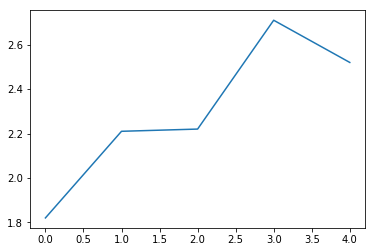

In [12]:
# mean reward over time
reward_mat = np.resize(np.array(rewards), [len(rewards) // 100, 100])
mean_reward = np.average(reward_mat, 1)
plt.plot(mean_reward)

## Next Steps

A number of improvements above and beyond the DQN architecture described by DeepMind (http://www.davidqiu.com:8888/research/nature14236.pdf), have allowed for even greater performance and stability.

### Double DQN

The main intuition behind Double DQN is that the regular DQN often overestimates the Q-values of the potential actions to take in a given state. While this would be fine if all actions were always overestimates equally, there was reason to believe this wasn’t the case. You can easily imagine that if certain suboptimal actions regularly were given higher Q-values than optimal actions, the agent would have a hard time ever learning the ideal policy. In order to correct for this, the authors of DDQN paper propose a simple trick: instead of taking the max over Q-values when computing the target-Q value for our training step, we use our primary network to chose an action, and our target network to generate the target Q-value for that action. By decoupling the action choice from the target Q-value generation, we are able to substantially reduce the overestimation, and train faster and more reliably. Below is the new DDQN equation for updating the target value.

Q-Target = r + γQ(s’,argmax(Q(s’,a,ϴ),ϴ’))

### Dueling DQN

In order to explain the reasoning behind the architecture changes that Dueling DQN makes, we need to first explain some a few additional reinforcement learning terms. The Q-values that we have been discussing so far correspond to how good it is to take a certain action given a certain state. This can be written as Q(s,a). This action given state can actually be decomposed into two more fundamental notions of value. The first is the value function V(s), which says simple how good it is to be in any given state. The second is the advantage function A(a), which tells how much better taking a certain action would be compared to the others. We can then think of Q as being the combination of V and A. More formally:

Q(s,a) =V(s) + A(a)

The goal of Dueling DQN is to have a network that separately computes the advantage and value functions, and combines them back into a single Q-function only at the final layer. It may seem somewhat pointless to do this at first glance. Why decompose a function that we will just put back together? The key to realizing the benefit is to appreciate that our reinforcement learning agent may not need to care about both value and advantage at any given time. For example: imagine sitting outside in a park watching the sunset. It is beautiful, and highly rewarding to be sitting there. No action needs to be taken, and it doesn’t really make sense to think of the value of sitting there as being conditioned on anything beyond the environmental state you are in. We can achieve more robust estimates of state value by decoupling it from the necessity of being attached to specific actions.

(From https://medium.com/@awjuliani/simple-reinforcement-learning-with-tensorflow-part-4-deep-q-networks-and-beyond-8438a3e2b8df)